In [1]:
import sys
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os

In [2]:
def make_cwnd_rtt(input1, input2, file_name):
    with open(file_name) as f:
        content = f.readlines()
    splitter = lambda x: x[:-1].split()
    split_input = list(map(splitter, content))
    time = list(map(lambda x: x[0], split_input))
    new_input1 = list(map(lambda x: x[1], split_input))
    new_input2 = list(map(lambda x: x[2], split_input))
    
    input1 = [float(x) + float(y) for x, y in zip(input1, new_input1)]
    input2 = [float(x) + float(y) for x, y in zip(input2, new_input2)]
    
    return input1, input2

In [3]:
time_length = 100

cwnd1 = [0] * time_length
cwnd2 = [0] * time_length
rtt1 = [0] * time_length
rtt2 = [0] * time_length

for i in range(10):
    os.system('ns simulation.tcl')
    
    cwnd1, cwnd2 = make_cwnd_rtt(cwnd1, cwnd2, 'cwnd')
    rtt1, rtt2 = make_cwnd_rtt(rtt1, rtt2, 'rtt')
    

cwnd1 = [x / 10 for x in cwnd1]    
cwnd2 = [x / 10 for x in cwnd2]
rtt1 = [x / 10 for x in cwnd1]    
rtt2 = [x / 10 for x in cwnd2]

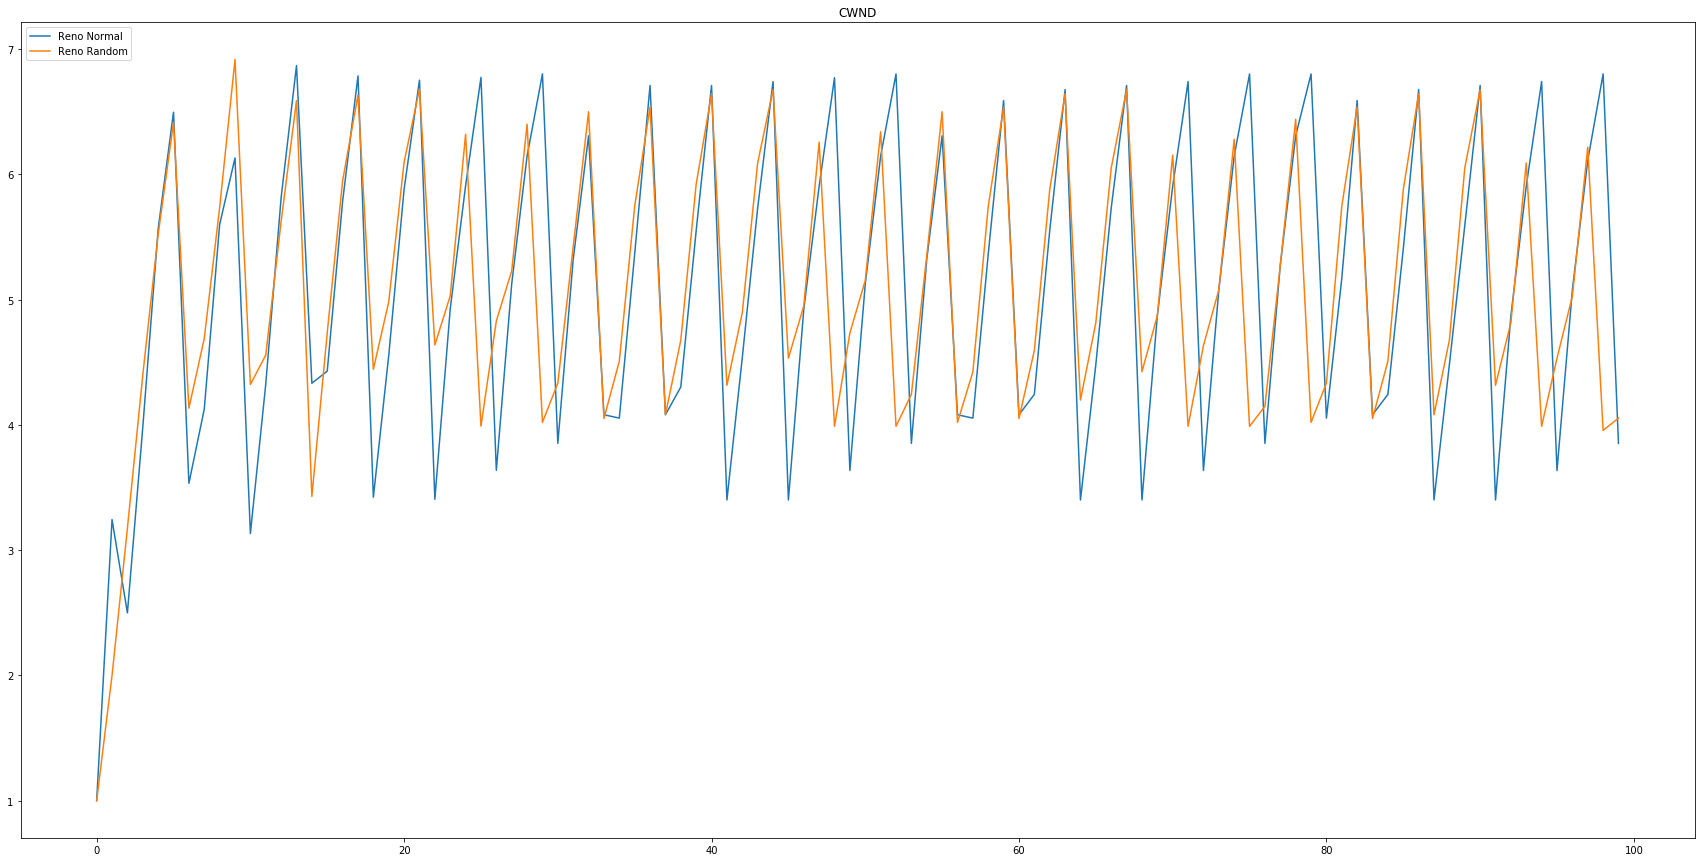

In [4]:
plt.figure(figsize=(30,15))
plt.plot(np.arange(time_length), cwnd1)
plt.plot(np.arange(time_length), cwnd2)
plt.legend(['Reno Normal', 'Reno Random'], loc='upper left')
plt.title('CWND')
plt.show()

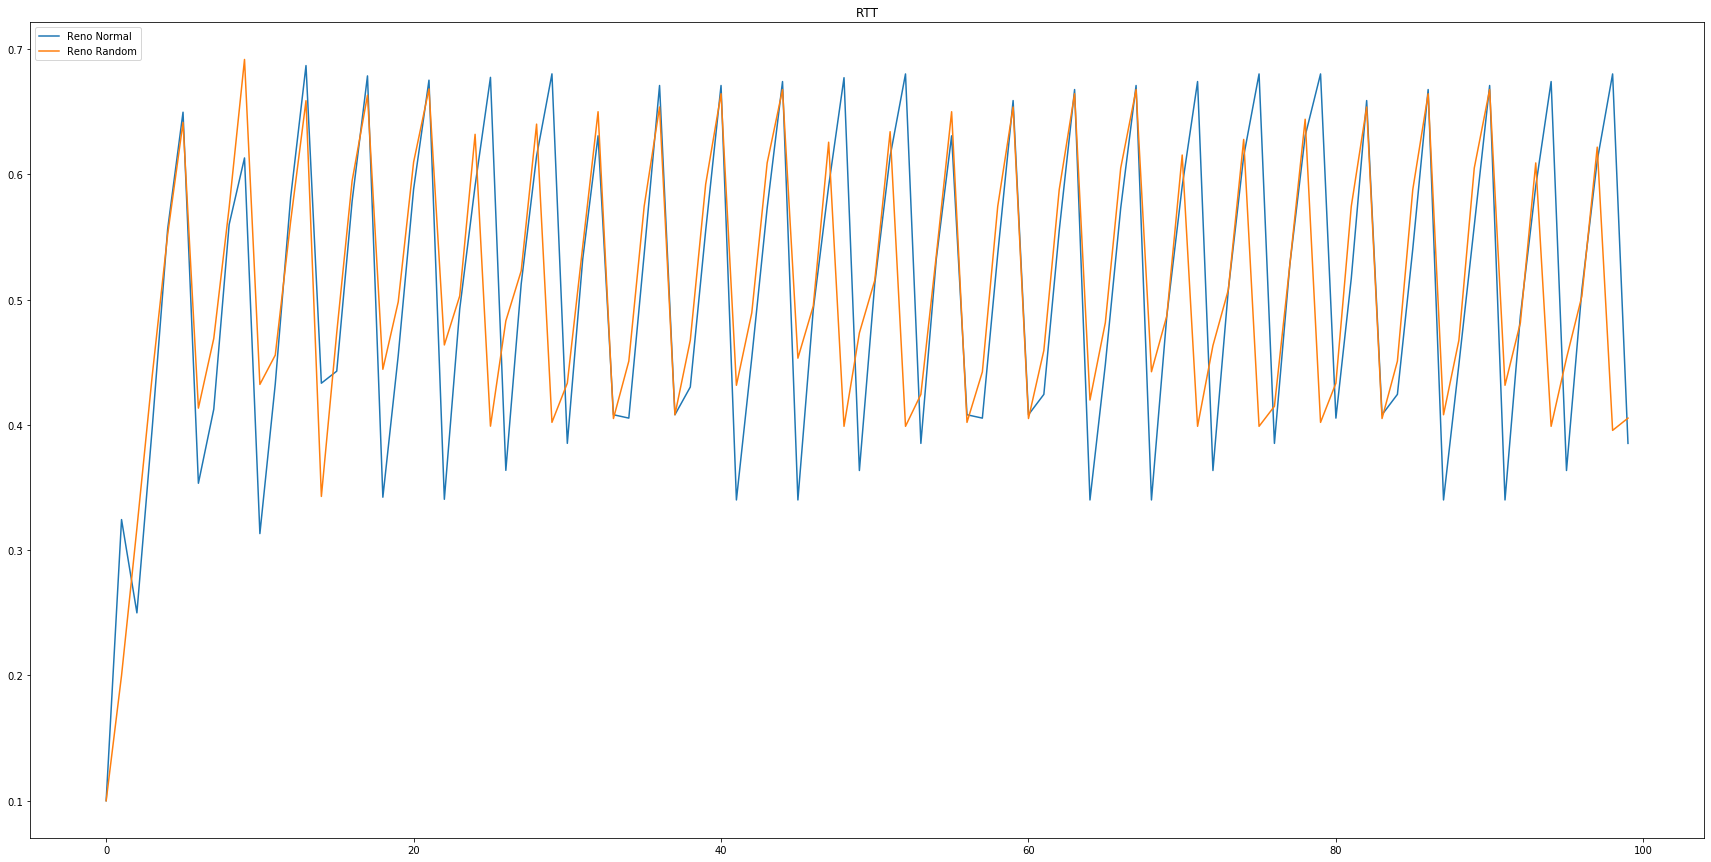

In [5]:
plt.figure(figsize=(30,15))
plt.plot(np.arange(time_length), rtt1)
plt.plot(np.arange(time_length), rtt2)
plt.legend(['Reno Normal', 'Reno Random'], loc='upper left')
plt.title('RTT')
plt.show()

In [6]:
filename = 'trace.tr'
with open(filename) as f:
    content = f.readlines()
split_drop = list(map(lambda x: x[:-1].split(), content))
drop_data = list(map(lambda x: x if 'd' in x else None, split_drop))
drop_data = list(filter((None).__ne__, drop_data))

drop_1 = list(map(lambda x: float(x[1]) if x[7] == '0' else None, drop_data))
drop_1 = list(filter((None).__ne__, drop_1))

drop_2 = list(map(lambda x: float(x[1]) if x[7] == '1' else None, drop_data))
drop_2 = list(filter((None).__ne__, drop_2))

print(len(drop_1))
print(len(drop_2))

26
27


In [7]:
split_packet = list(map(lambda x: x[:-1].split(), content))
packet_data = list(map(lambda x: x if '+' in x else None, split_packet))
packet_data = list(filter((None).__ne__, packet_data))

packet_1 = list(map(lambda x: float(x[1]) if x[2] == '0' and x[3] == '2' else None, packet_data))
packet_1 = list(filter((None).__ne__, packet_1))

packet_2 = list(map(lambda x: float(x[1]) if x[2] == '1' and x[3] == '2' else None, packet_data))
packet_2 = list(filter((None).__ne__, packet_2))

print(len(packet_1))
print(len(packet_2))

675
636


In [8]:
time = list(np.arange(0.0, 99, 1))

def get_packet_loss(lost_packets, packets):
    packet_loss = []
    j, k = 0 ,0
    prev_i = 0
    for i in np.arange(0.0, 100.0, 1):
        lost_num = 0
        packets_num = 0
        while(j < len(lost_packets) and lost_packets[j] < i):
            lost_num += 1
            j += 1
        while(k < len(packets) and packets[k] < i):
            packets_num += 1
            k += 1
        if(packets_num):
            packet_loss.append(lost_num/packets_num)
#         prev_i = i
    return packet_loss
packet_loss1 = get_packet_loss(drop_1, packet_1)
packet_loss2 = get_packet_loss(drop_2, packet_2)

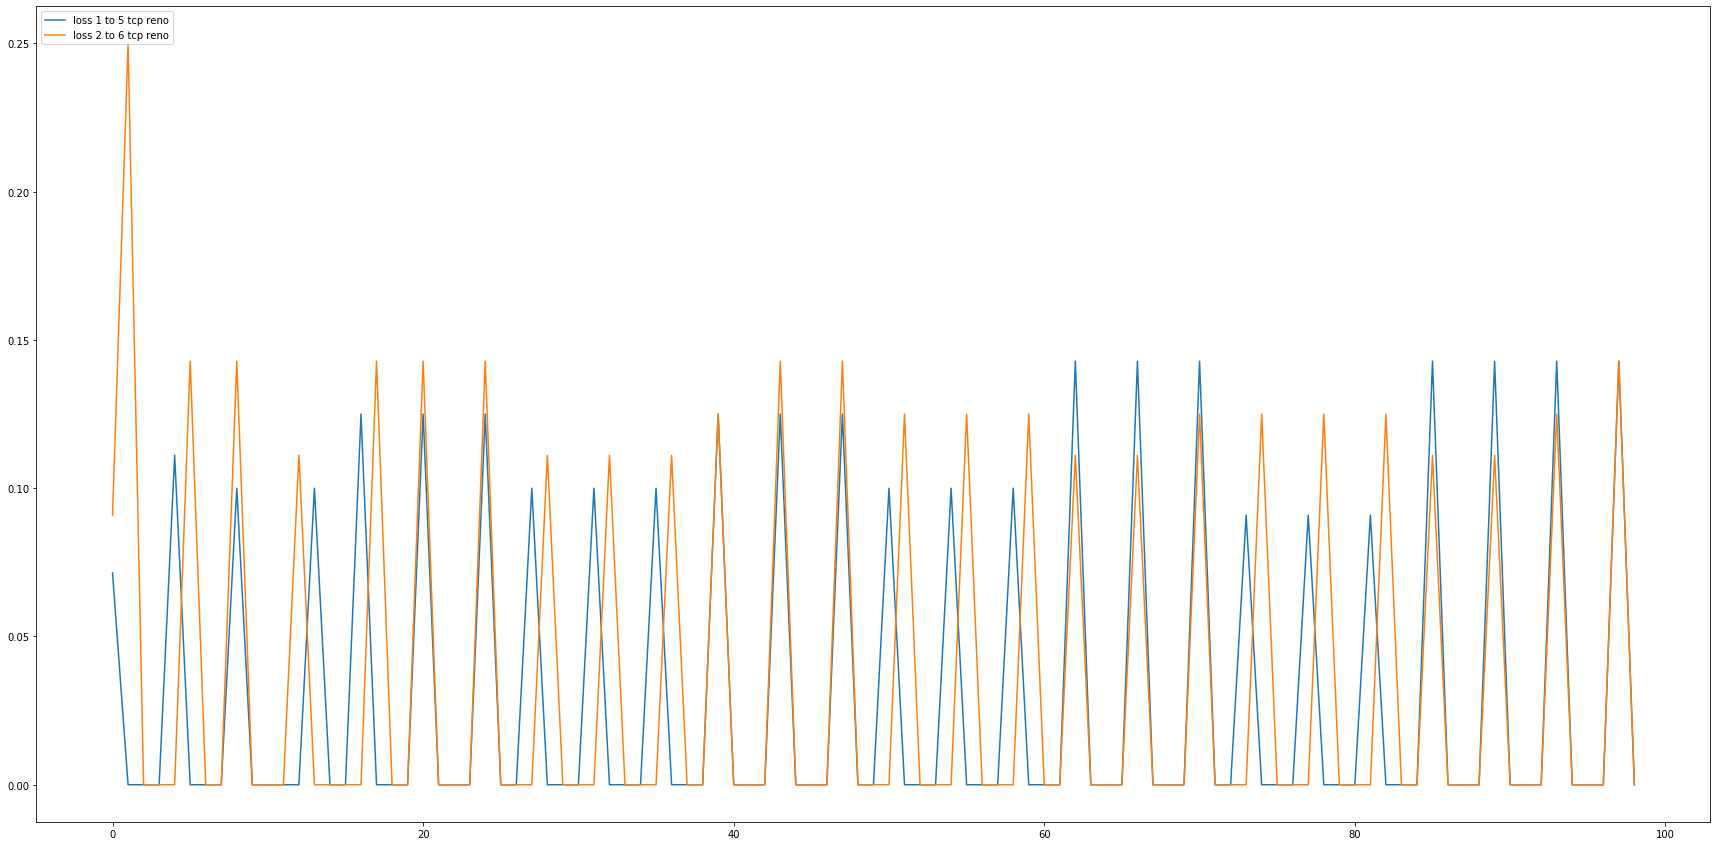

In [9]:
plt.figure(figsize=(30,15))
plt.plot(time, packet_loss1)
plt.plot(time, packet_loss2)
plt.legend(['loss 1 to 5 tcp reno', 'loss 2 to 6 tcp reno'], loc='upper left')
plt.show()
# len(packet_loss2)

In [10]:
filename = 'trace.tr'
with open(filename) as f:
    content = f.readlines()
split_received = list(map(lambda x: x[:-1].split(), content))
received_data = list(map(lambda x: x if x[0] == 'r' else None, split_received))
received_data = list(filter((None).__ne__, received_data))

received_1 = list(map(lambda x: float(x[1]) if x[2] == '3' and x[3] == '4' else None, received_data))
received_1 = list(filter((None).__ne__, received_1))

received_2 = list(map(lambda x: float(x[1]) if x[2] == '3' and x[3] == '5' else None, received_data))
received_2 = list(filter((None).__ne__, received_2))

# print((received_1))

In [11]:
def get_goodput(received, loss):
    goodput = list()
    received_idx = 0
    loss_idx = 0
    loss_ended = False

    for t in range(1, 101):
        t_goodput = 0
        while (not loss_ended) and (loss_idx < len(loss) and loss[loss_idx] < t - 1):
            loss_idx += 1
        if loss_idx == len(loss) and received[received_idx] >= loss[loss_idx-1]:
            loss_ended = True
            loss_idx -= 1
            
        while received_idx < len(received) and received[received_idx] < t - 1:
            received_idx += 1
            
        while received_idx < len(received) and (loss_ended or received[received_idx] < loss[loss_idx]) and received[received_idx] < t :
            t_goodput += 1
            received_idx += 1
        goodput.append(t_goodput * 1000 * 8)
        
    return goodput

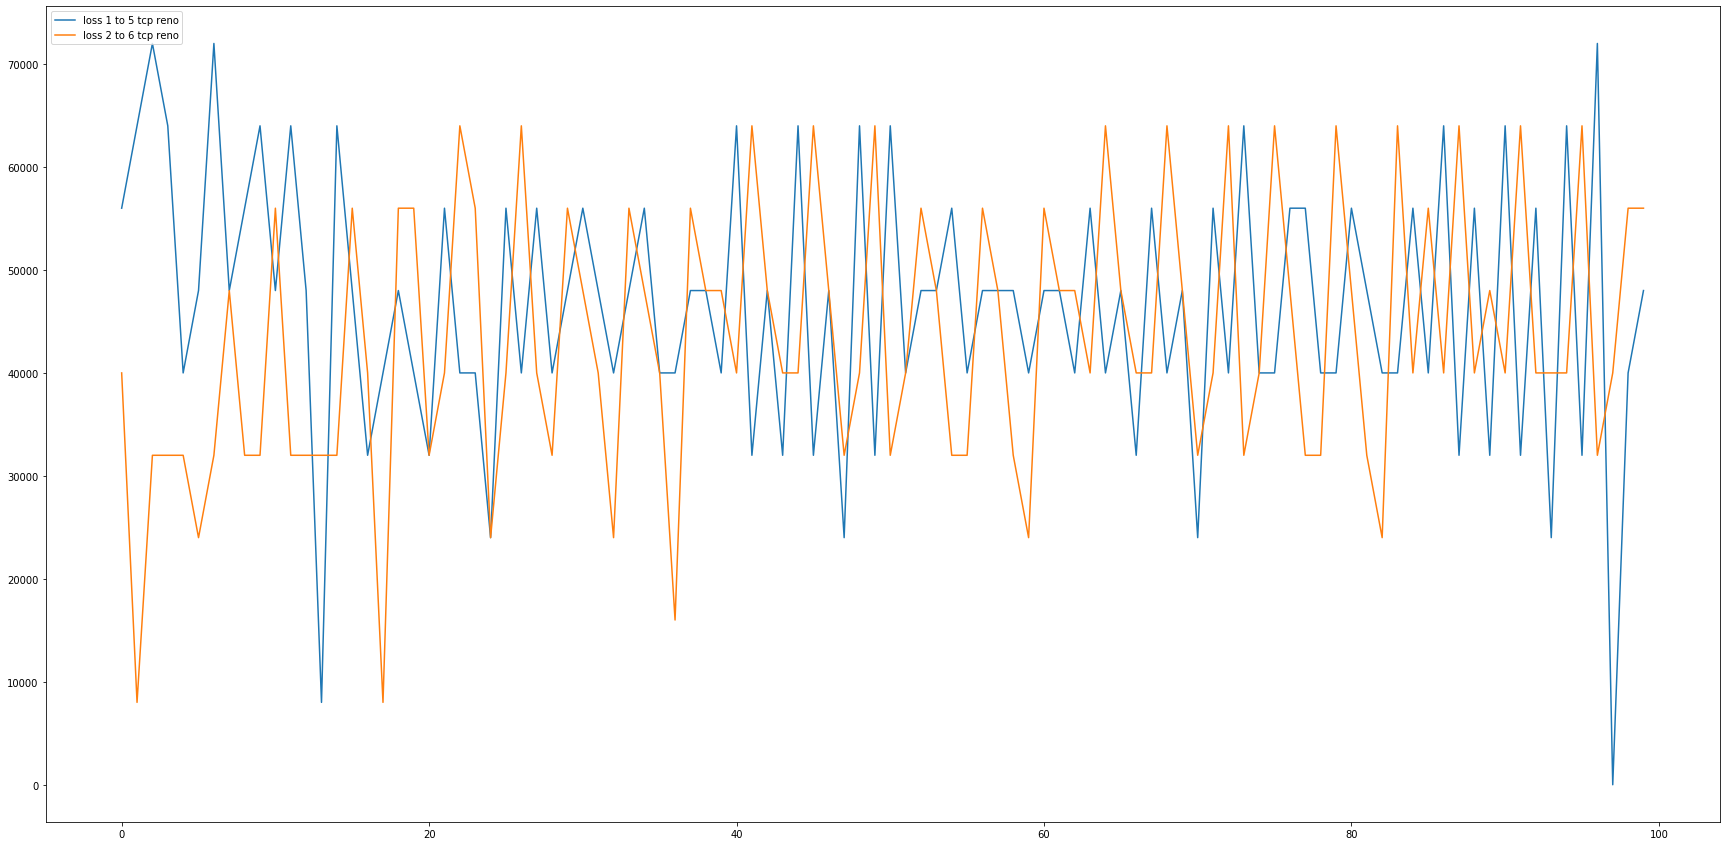

In [12]:
goodput_1 = get_goodput(received_1, drop_1)
goodput_2 = get_goodput(received_2, drop_2)

plt.figure(figsize=(30,15))
plt.plot(np.arange(100), goodput_1)
plt.plot(np.arange(100), goodput_2)
plt.legend(['loss 1 to 5 tcp reno', 'loss 2 to 6 tcp reno'], loc='upper left')
plt.show()